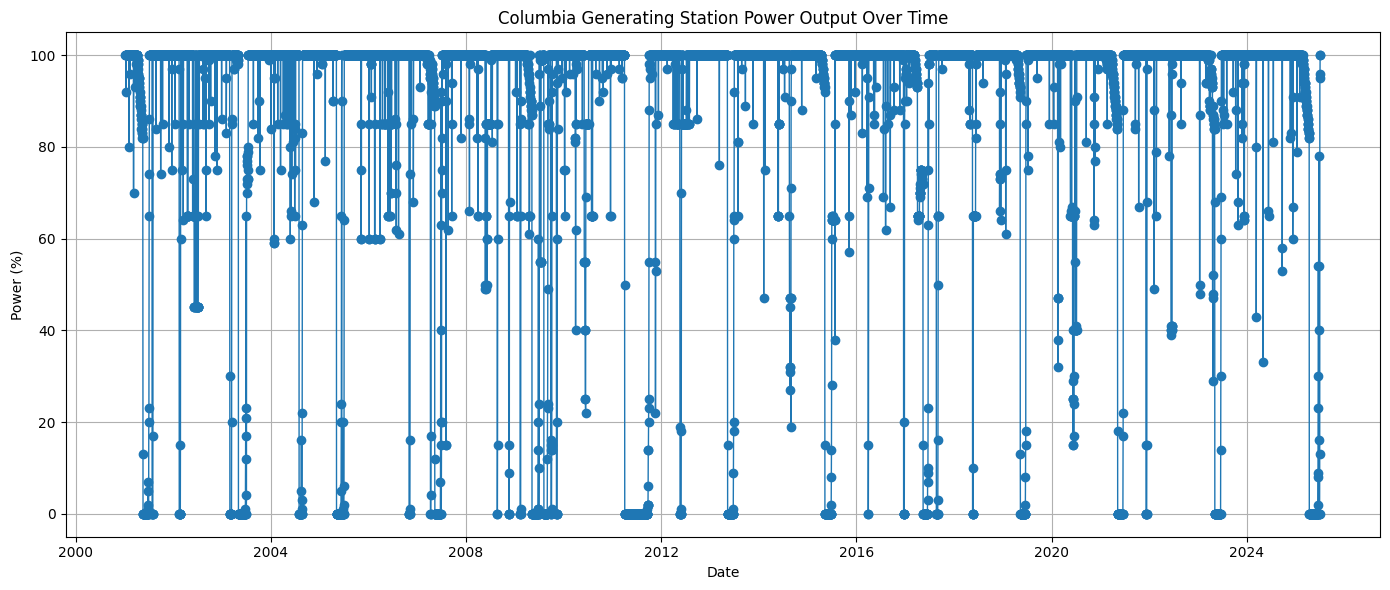

In [2]:
import os
import django
import pandas as pd
import matplotlib.pyplot as plt
from threading import Thread
from queue import Queue

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "nucleartimeseries_api.settings")
django.setup()

from nrc_data.models import ReactorStatus

# Threaded function to fetch data
def get_data_thread(q):
    qs = ReactorStatus.objects.filter(unit__icontains="Columbia Generating Station").order_by('report_date')
    q.put(list(qs.values("report_date", "power")))

# Use thread to execute ORM
q = Queue()
t = Thread(target=get_data_thread, args=(q,))
t.start()
t.join()
data = q.get()

# Plot
df = pd.DataFrame(data)
plt.figure(figsize=(14, 6))
plt.plot(df["report_date"], df["power"], marker="o", linestyle="-", linewidth=1)
plt.title("Columbia Generating Station Power Output Over Time")
plt.xlabel("Date")
plt.ylabel("Power (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import plotly.express as px

# Convert to DataFrame (already done above)
df = pd.DataFrame(data)

# Plot with Plotly
fig = px.line(
    df,
    x="report_date",
    y="power",
    title="Columbia Generating Station Power Output Over Time"
)

# Add zoom and horizontal scroll
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis_title="Power (%)",
    xaxis_title="Date"
)

fig.show()


In [4]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objects as go

# Convert to DataFrame
df = pd.DataFrame(data)

# Rename for Prophet
df_prophet = df.rename(columns={
    "report_date": "ds",
    "power": "y"
})

# STEP 1: Identify refueling outages (power == 0, optional 'reason' if available)
# If you have a 'reason' field with "refueling", use that instead.
refuel_days = df_prophet[df_prophet["y"] == 0]

# STEP 2: Create holidays DataFrame
holidays = pd.DataFrame({
    "holiday": "refueling_outage",
    "ds": refuel_days["ds"],
    "lower_window": 0,
    "upper_window": 5  # assume outages may affect 5 days around the drop
})

# STEP 3: Initialize Prophet with holidays
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.5,
    holidays=holidays
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)


# STEP 4: Fit model
model.fit(df_prophet)

# STEP 5: Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


/home/ballaprr/Documents/NuclearTimeSeries/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

04:48:20 - cmdstanpy - INFO - Chain [1] start processing
04:48:21 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], mode='lines', name='Actual Power Output'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecasted Power Output'))

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(width=0), name='Upper Bound', showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', fill='tonexty', line=dict(width=1), name='Lower Bound', showlegend=False))


fig.update_layout(
    title="Columbia Generating Station Power Forecast",
    xaxis_title="Date",
    yaxis_title="Power (%)",
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    template="plotly_white"
)

fig.show()

In [6]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

  0%|          | 0/42 [00:00<?, ?it/s]04:48:30 - cmdstanpy - INFO - Chain [1] start processing
04:48:30 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/42 [00:00<00:17,  2.32it/s]04:48:31 - cmdstanpy - INFO - Chain [1] start processing
04:48:31 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/42 [00:00<00:20,  2.00it/s]04:48:31 - cmdstanpy - INFO - Chain [1] start processing
04:48:31 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/42 [00:01<00:20,  1.86it/s]04:48:32 - cmdstanpy - INFO - Chain [1] start processing
04:48:32 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 4/42 [00:02<00:20,  1.87it/s]04:48:32 - cmdstanpy - INFO - Chain [1] start processing
04:48:33 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 5/42 [00:02<00:20,  1.78it/s]04:48:33 - cmdstanpy - INFO - Chain [1] start processing
04:48:33 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 6/42 [00:03<00:20,  1.75it/s]04:48:34

  horizon         mse       rmse       mae     mdape     smape  coverage
0 37 days  150.603522  12.272063  5.419969  0.030300  0.151001  0.946506
1 38 days  152.708305  12.357520  5.456230  0.030423  0.152941  0.946195
2 39 days  149.518482  12.227775  5.445207  0.030609  0.154768  0.945854
3 40 days  147.139096  12.130091  5.438069  0.030832  0.156876  0.945512
4 41 days  147.798430  12.157238  5.483383  0.031137  0.159883  0.943211


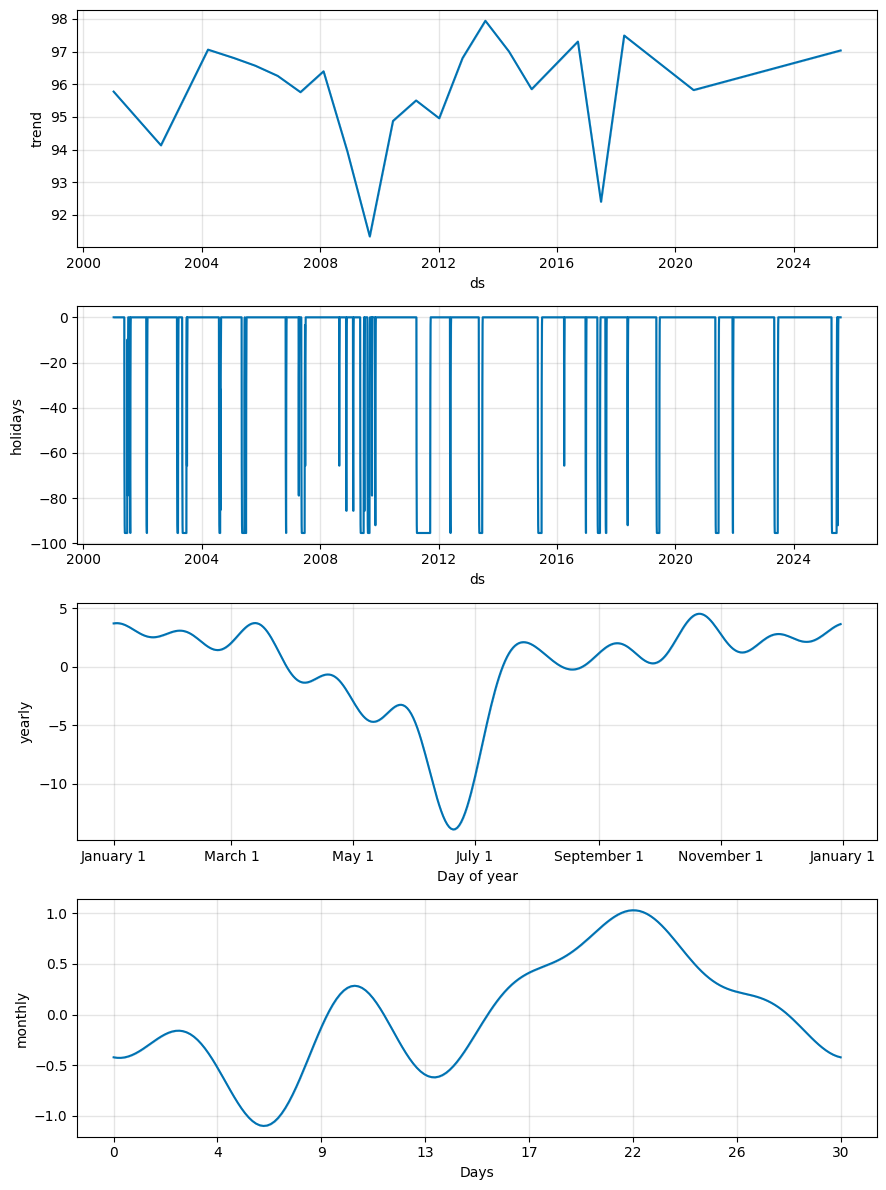

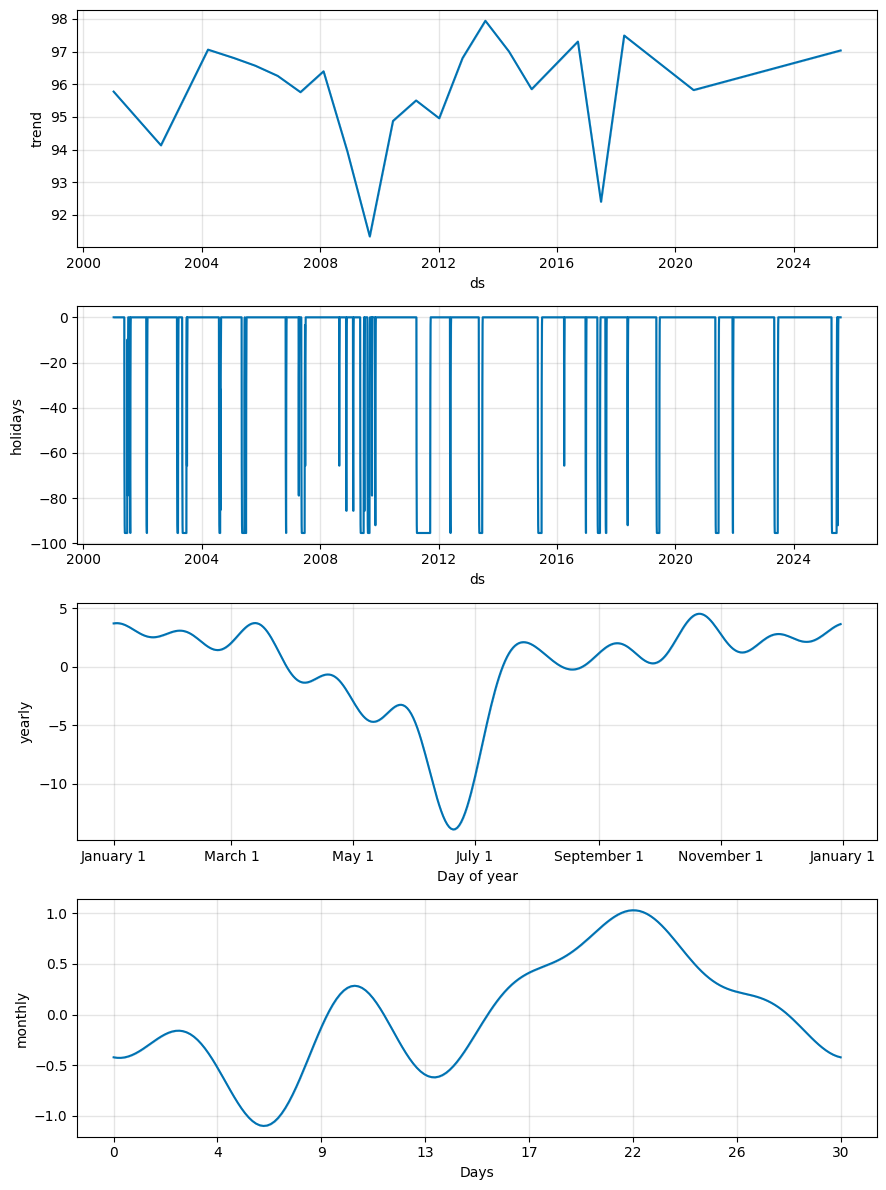

In [7]:
model.plot_components(forecast)


In [11]:
future = model.make_future_dataframe(periods=30)
future


,ds
0,2001-01-08
1,2001-01-09
2,2001-01-10
3,2001-01-11
4,2001-01-12
...,...
8945,2025-07-29
8946,2025-07-30
8947,2025-07-31
8948,2025-08-01


In [19]:
print(forecast[['ds']].tail())
print("Latest date in original data:", df_prophet['ds'].max())


             ds
8945 2025-07-29
8946 2025-07-30
8947 2025-07-31
8948 2025-08-01
8949 2025-08-02
Latest date in original data: 2025-07-03


In [23]:
latest_date = pd.to_datetime('2025-07-03')
next_day = latest_date + pd.Timedelta(days=1)
next_day_forecast = forecast[forecast['ds'] == next_day]
print(next_day_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


TypeError: can only concatenate str (not "Timedelta") to str

AttributeError: 'datetime.date' object has no attribute 'date'